In [14]:
# last updated date: 2/25/2025
# thyroid cancer visualization

In [15]:

import numpy as np
import pandas as pd
import pickle
import random
import timeit
import os

from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume
from matplotlib import pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from thyroid_cancer_prob_two_original import ThyroidProblem

from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# fetch dataset
differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915)

np.random.seed(42)
random.seed(42)

# Set pandas options to display all rows and columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Disable line wrapping
pd.set_option("display.max_colwidth", None)  # Disable truncation for column width


def process_data():
    # read the data
    X = differentiated_thyroid_cancer_recurrence.data.features
    y = differentiated_thyroid_cancer_recurrence.data.targets
    min_value = X[["Age"]].min()
    max_value = X[["Age"]].max()

    return X, y, min_value, max_value


def train_and_save_model(data_wo_label, target_class, model_filename):
    categorical_columns = [
        "Gender",
        "Smoking",
        "Hx Smoking",
        "Hx Radiothreapy",
        "Thyroid Function",
        "Physical Examination",
        "Adenopathy",
        "Pathology",
        "Focality",
        "Risk",
        "T",
        "N",
        "M",
        "Stage",
        "Response",
    ]

    # apply one-hot encoding to the categorical columns
    data_for_model = pd.get_dummies(data_wo_label, columns=categorical_columns)

    # convert boolean values to int
    data_for_model = data_for_model.astype(int)
    #print("data for model", data_for_model)
    X = data_for_model
    y = target_class
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # standardize the numerical features before training the model
    numerical_features = ["Age"]
    categorical_features = data_for_model.columns.difference(
        numerical_features
    ).tolist()  # get all one-hot encoded column names dynamically

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_features),
            ("cat", "passthrough", categorical_features),
        ]
    )  # leave categorical features untransformed

    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", MLPClassifier(random_state=42)),
        ]
    )
    # model = MLPClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # save the trained model
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved as {model_filename}")


def load_model(model_filename, data_wo_label, target_class):
    # check if the model file exists
    if os.path.exists(model_filename):
        # load the existing model
        with open(model_filename, "rb") as file:
            loaded_model = pickle.load(file)
        print(f"Model loaded from existing file, {model_filename}")
    else:
        print(f"Model file {model_filename} is missing.")
        # if the model file is missing, train and save a new model
        train_and_save_model(data_wo_label, target_class, model_filename)
        # reload the newly saved model
        with open(model_filename, "rb") as file:
            loaded_model = pickle.load(file)
        print(f"Model reloaded from {model_filename}")

    return loaded_model


In [16]:

def save_hist_FX(hist_F, hist_X, extracted_data_name, pop_size, sample_idx, ref_point):

    # Process hist_F and hist_X to save in a .csv file
    data = []
    f1_values = []
    f2_values = []
    for f_arr, x_list in zip(hist_F, hist_X):
        for f, x in zip(f_arr, x_list):
            # Flatten and combine F and X values
            row = {"F1": f[0], "F2": f[1], "X": x}
            data.append(row)

            # Save the f1 and f2 values for plotting
            f1_values.append(f[0])
            f2_values.append(f[1])

    # Convert to df
    df = pd.DataFrame(data)
    print("shape of history: ", df.shape)
    print(df.head())
    

In [17]:

X, y, min_values, max_values = process_data()
extracted_data_name = "thyroid_cancer"
model_filename = "thyroid_model.pkl"
loaded_model = load_model(model_filename, X, y)

combined_data = pd.concat([X, y], axis=1)

# select 10 good samples from the data
good_samples = combined_data[combined_data["Recurred"] == "No"].sample(
    n=10, random_state=42
)
good_samples = good_samples.drop(columns=["Recurred"])  # drop the target variable
#print("good sample list", good_samples)

idx = 259
good_sample = good_samples.loc[idx]
print("good sample: \n", good_sample)

problem = ThyroidProblem(
    loaded_model,
    original_sample=good_sample,
    sample_idx=idx,
    desired_class="Yes",
    min_values=min_values,
    max_values=max_values,
)

# set the population size
pop_size = 100

# initialize the algorithm
algorithm = MixedVariableGA(
    pop_size=pop_size, survival=RankAndCrowdingSurvival()
)

Model loaded from existing file, thyroid_model.pkl
good sample: 
 Age                                              48
Gender                                            F
Smoking                                          No
Hx Smoking                                       No
Hx Radiothreapy                                  No
Thyroid Function                          Euthyroid
Physical Examination    Single nodular goiter-right
Adenopathy                                       No
Pathology                                 Papillary
Focality                                Multi-Focal
Risk                                            Low
T                                               T3a
N                                                N0
M                                                M0
Stage                                             I
Response                              Indeterminate
Name: 259, dtype: object


In [18]:
# run the optimization
res = minimize(
    problem, algorithm, ("n_gen", 100), seed=1, save_history=True, verbose=False
)

for f1, f2 in zip(problem.all_f1, problem.all_f2):
    print(f"f1: {f1}, f2: {f2}\n")


f1: 0.03753085371553158, f2: 0.0642417235722234

f1: 0.03838632185484771, f2: 0.578921440342301

f1: 0.25967436529191823, f2: 0.671237273701361

f1: 0.9701801260775421, f2: 0.8044175918648173

f1: 0.7529444136368263, f2: 0.8995295675771519

f1: 0.0014143073204402631, f2: 0.4478104636401144

f1: 0.12717018447430045, f2: 0.9310293621816014

f1: 4.441484518114053e-05, f2: 0.7744657751376942

f1: 0.2809257359700923, f2: 0.16269945445515338

f1: 0.6434379114494405, f2: 0.4496800119285497

f1: 0.26622617530511405, f2: 0.3143446159939693

f1: 0.948556815441992, f2: 0.38858173306880206

f1: 0.9563881219307746, f2: 0.6065886422393169

f1: 0.005498127481938923, f2: 0.10723897768248514

f1: 0.07913837473258097, f2: 0.08043704746380721

f1: 0.03499218028668234, f2: 0.511676124865254

f1: 0.002445707498814202, f2: 0.4552526450256517

f1: 0.9881405056361677, f2: 0.5453389087101791

f1: 0.001541619467219442, f2: 0.6766131687270867

f1: 0.03679968792515461, f2: 0.7347844800419098

f1: 0.01173091473616

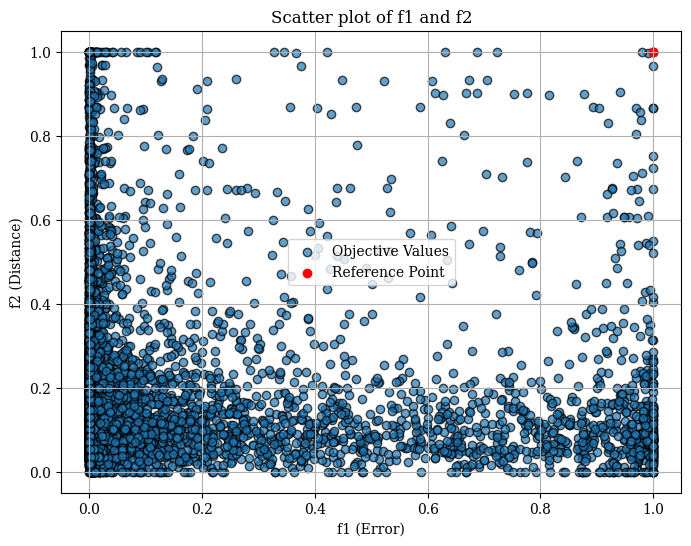

In [19]:

# create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    problem.all_f1,
    problem.all_f2,
    alpha=0.7,
    edgecolors="k",
    label="Objective Values",
)
plt.scatter(
    problem.max_error, problem.max_distance, color="red", label="Reference Point"
)
plt.title("Scatter plot of f1 and f2")
plt.xlabel("f1 (Error)")
plt.ylabel("f2 (Distance)")
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.5))
plt.grid(True)
plt.show()


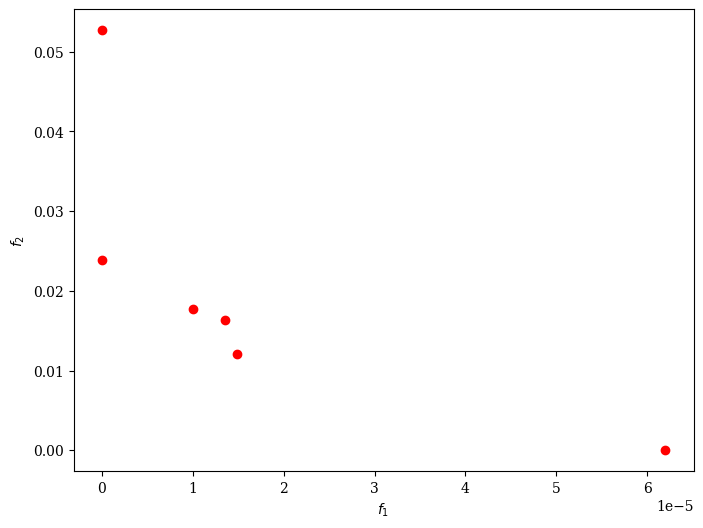

In [20]:

X, F = res.opt.get("X", "F")

# create a scatter plot of the Pareto front
plot = Scatter()
plot.add(res.F, color="red")
plot.show()


In [21]:

# save the dots
pareto_front = res.F
pareto_front_df = pd.DataFrame(pareto_front, columns=["Error", "Distance"])
print(pareto_front_df)



          Error  Distance
0  0.000000e+00  0.052666
1  1.483288e-05  0.012139
2  7.476968e-08  0.023880
3  1.357030e-05  0.016295
4  1.002465e-05  0.017720
5  6.198782e-05  0.000000


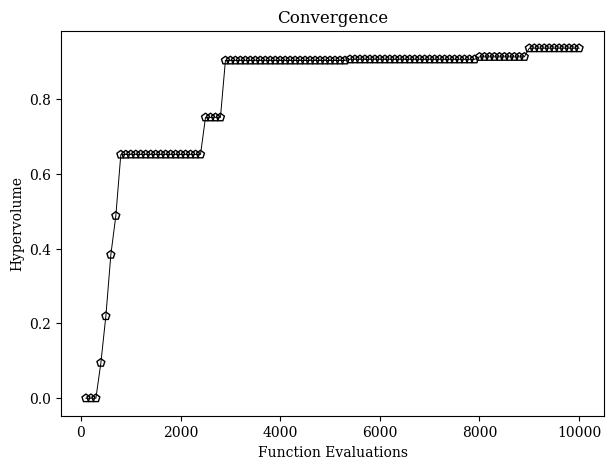

In [22]:

hist = res.history

n_evals = []  # number of evaluations
hist_F = []  # objective space values in each generation
hist_X = []  # design variable values in each generation

for algo in hist:
    n_evals.append(algo.evaluator.n_eval)
    opt = algo.opt

    feas = np.where(opt.get("feasible"))[0]

    hist_F.append(opt.get("F")[feas])
    hist_X.append(opt.get("X")[feas])

# hypervolume (HV)
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

buffer = 0.1
ref_point = np.array([problem.max_error + buffer, problem.max_distance + buffer])
metric = Hypervolume(
    ref_point=ref_point,
    norm_ref_point=False,
    zero_to_one=True,
    ideal=approx_ideal,
    nadir=approx_nadir,
)

hv = [metric.do(_F) for _F in hist_F]
plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv, color="black", lw=0.7)
plt.scatter(n_evals, hv, facecolor="none", edgecolor="black", marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()


In [23]:

# save the hypervolume values to a file
hv_df = pd.DataFrame(hv)
print("Hypervolume values: ")
print(hv_df)


Hypervolume values: 
           0
0   0.000000
1   0.000000
2   0.000000
3   0.094705
4   0.219429
5   0.383490
6   0.487418
7   0.651017
8   0.651017
9   0.651365
10  0.651365
11  0.651365
12  0.651365
13  0.651365
14  0.651365
15  0.651365
16  0.651365
17  0.651365
18  0.651365
19  0.651365
20  0.651365
21  0.651365
22  0.651365
23  0.651365
24  0.750372
25  0.750372
26  0.750372
27  0.750372
28  0.902460
29  0.902460
30  0.902460
31  0.902460
32  0.902460
33  0.902460
34  0.902460
35  0.902460
36  0.902460
37  0.902460
38  0.902460
39  0.902460
40  0.902460
41  0.902460
42  0.902460
43  0.902460
44  0.902460
45  0.902460
46  0.902460
47  0.902460
48  0.902460
49  0.902460
50  0.902460
51  0.902460
52  0.902460
53  0.905393
54  0.905393
55  0.905393
56  0.905393
57  0.905393
58  0.905393
59  0.905393
60  0.905393
61  0.905393
62  0.905393
63  0.905393
64  0.905393
65  0.905393
66  0.905393
67  0.905393
68  0.905393
69  0.905393
70  0.905393
71  0.905393
72  0.905393
73  0.905393
74  

In [36]:

def log_results(genomes, good_sample, data_wo_label):
    col_list = list(X[0].keys())

    # display the original good sample
    val_dict = dict(zip(col_list, good_sample))
    print("Good sample: ")
    print(f"{val_dict},\n")
    
    # log the generated counterfactuals
    print("Generated counterfactuals: ")
    for i, genome in enumerate(genomes):
        genome_dict = dict(zip(col_list, genome.values()))

        print(f"{i+1}: {genome_dict},\n")


In [25]:
print(f"good sample index {idx}: \n", good_sample)


good sample index 259: 
 Age                                              48
Gender                                            F
Smoking                                          No
Hx Smoking                                       No
Hx Radiothreapy                                  No
Thyroid Function                          Euthyroid
Physical Examination    Single nodular goiter-right
Adenopathy                                       No
Pathology                                 Papillary
Focality                                Multi-Focal
Risk                                            Low
T                                               T3a
N                                                N0
M                                                M0
Stage                                             I
Response                              Indeterminate
Name: 259, dtype: object


In [37]:
log_results(problem.all_genomes, good_sample, X)


Good sample: 
{'Age': 48, 'Gender': 'F', 'Smoking': 'No', 'Hx Smoking': 'No', 'Hx Radiothreapy': 'No', 'Thyroid Function': 'Euthyroid', 'Physical Examination': 'Single nodular goiter-right', 'Adenopathy': 'No', 'Pathology': 'Papillary', 'Focality': 'Multi-Focal', 'Risk': 'Low', 'T': 'T3a', 'N': 'N0', 'M': 'M0', 'Stage': 'I', 'Response': 'Indeterminate'},

Generated counterfactuals: 
1: {'Age': 48, 'Gender': 'M', 'Smoking': 'No', 'Hx Smoking': 'Yes', 'Hx Radiothreapy': 'No', 'Thyroid Function': 'Euthyroid', 'Physical Examination': 'Multinodular goiter', 'Adenopathy': 'No', 'Pathology': 'Micropapillary', 'Focality': 'Multi-Focal', 'Risk': 'High', 'T': 'T4a', 'N': 'N0', 'M': 'M0', 'Stage': 'I', 'Response': 'Structural Incomplete'},

2: {'Age': 49, 'Gender': 'M', 'Smoking': 'No', 'Hx Smoking': 'No', 'Hx Radiothreapy': 'Yes', 'Thyroid Function': 'Subclinical Hypothyroidism', 'Physical Examination': 'Multinodular goiter', 'Adenopathy': 'No', 'Pathology': 'Hurthel cell', 'Focality': 'Multi-Fo

In [38]:
# this prints the head() of history of F and X
save_hist_FX(hist_F, hist_X, extracted_data_name, pop_size, idx, ref_point)

shape of history:  (546, 3)
         F1        F2  \
0  0.000165  0.141491   
1  0.000167  0.030279   
2  0.001709  0.023282   
3  0.000000  0.739766   
4  0.000092  0.209132   

                                                                                                                                                                                                                                                                                                                                                                                      X  
0                                          {'Age': 41, 'Gender': 'M', 'Smoking': 'No', 'Hx Smoking': 'No', 'Hx Radiothreapy': 'Yes', 'Thyroid Function': 'Euthyroid', 'Physical Examination': 'Normal', 'Adenopathy': 'No', 'Pathology': 'Papillary', 'Focality': 'Uni-Focal', 'Risk': 'High', 'T': 'T3b', 'N': 'N1a', 'M': 'M0', 'Stage': 'IVA', 'Response': 'Biochemical Incomplete'}  
1           {'Age': 47, 'Gender': 'F', 'Smoking': 'No', 'Hx Smoki